---
title: PCA
format:
  html:
    toc: true
    toc-depth: 5
    toc-location: right
    code-fold: false
    theme:
      - cosmo
      - cerulean
    callout-icon: false
jupyter: python3
---

::: {.callout-note}
## Learning Outcomes
- Discuss the dimensionality of a dataset and strategies for dimensionality reduction
- Derive and carry out the procedure of PCA
- [**Optional for Fall 25**] Dissect Singular Value Decomposition (SVD) and use it to calculate principal components
- Develop a deeper understanding of how to interpret Principal Component Analysis (PCA)
- See applications of PCA in some real-world contexts
:::

So far in this course, we've focused on **supervised learning** techniques that create a function to map inputs (features) to labelled outputs. Regression and classification are two main examples, where the output value of regression is *quantitative* while the output value of classification is *categorical*. 

Today, we'll introduce an **unsupervised learning** technique called PCA. Unlike supervised learning, unsupervised learning is applied to *unlabeled* data. Because we have features but no labels, we aim to identify patterns in those features. Principal Component Analysis (PCA) is a linear technique for dimensionality reduction, and PCA relies on a linear algebra algorithm called Singular Value Decomposition, which we will discuss more in the next lecture.

## Visualization (Revisited)

Visualization can help us identify clusters or patterns in our dataset, and it can give us an intuition about our data and how to clean it for the model. For this demo, we'll return to the MPG dataset from Lecture 19 and see how far we can push visualization for multiple features.

In [1]:
#| code-fold: true
import pandas as pd
import numpy as np
import scipy as sp
import plotly.express as px
import seaborn as sns

In [2]:
#| code-fold: true
mpg = sns.load_dataset("mpg").dropna()
mpg.head()

mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436          11.0   
3  16.0          8         304.0       150.0    3433          12.0   
4  17.0          8         302.0       140.0    3449          10.5   

   model_year origin                       name  
0          70    usa  chevrolet chevelle malibu  
1          70    usa          buick skylark 320  
2          70    usa         plymouth satellite  
3          70    usa              amc rebel sst  
4          70    usa                ford torino

We can plot one feature as a histogram to see it's distribution. Since we only plot one feature, we consider this a 1-dimensional plot. 

In [3]:
#| code-fold: true
px.histogram(mpg, x="displacement")

We can also visualize two features (2-dimensional scatter plot): 

In [4]:
#| code-fold: true
px.scatter(mpg, x="displacement", y="horsepower")

Three features (3-dimensional scatter plot):

In [5]:
#| code-fold: true
fig = px.scatter_3d(mpg, x="displacement", y="horsepower", z="weight",
                    width=800, height=800)
fig.update_traces(marker=dict(size=3))

We can even push to 4 features using a 3D scatter plot and a colorbar: 

In [6]:
#| code-fold: true
fig = px.scatter_3d(mpg, x="displacement", 
                    y="horsepower", 
                    z="weight", 
                    color="model_year",
                    width=800, height=800, 
                    opacity=.7)
fig.update_traces(marker=dict(size=5))

Visualizing 5 features is also possible if we make the scatter dots unique to the datapoint's origin.

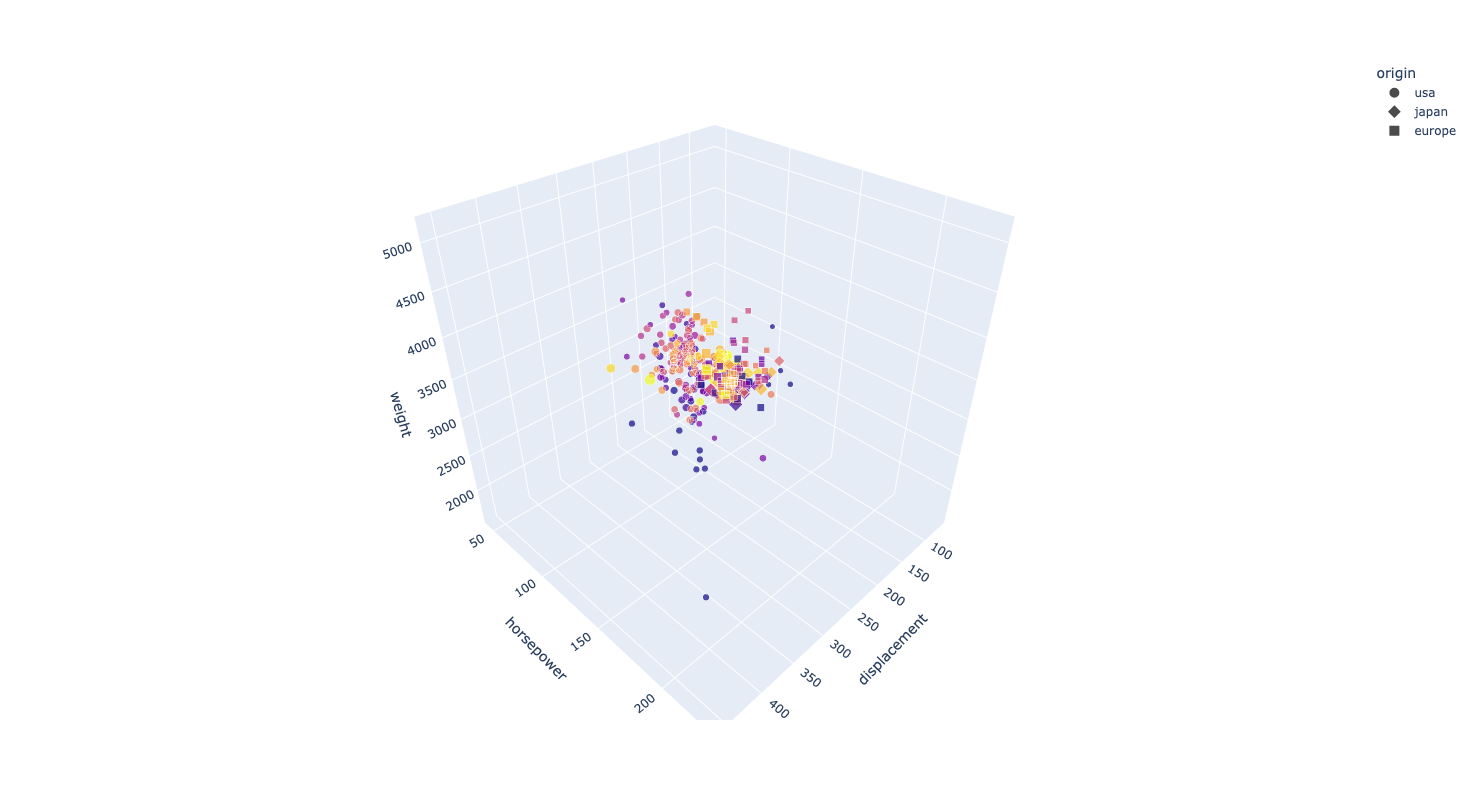

In [7]:
#| code-fold: true
fig = px.scatter_3d(mpg, x="displacement", 
                    y="horsepower", 
                    z="weight", 
                    color="model_year",
                    size="mpg",
                    symbol="origin",
                    width=900, height=800, 
                    opacity=.7)
# hide color scale legend on the plotly fig
fig.update_layout(coloraxis_showscale=False)

However, adding more features to our visualization can make our plot look messy and uninformative, and it can also be near impossible if we have a large number of features. The problem is that many datasets come with more than 5 features — hundreds, even. Is it still possible to visualize all those features? 

## Dimensionality
Suppose we have a dataset of:

- $N$ observations (datapoints/rows)
- $d$ attributes (features/columns)

Let's "rename" this in terms of linear algebra so that we can be more clear with our wording. Using linear algebra, we can view our matrix as: 

- $N$ **points/row vectors** in a $d$-Dimensional space, OR
- $d$ column vectors in an $N$-Dimensional space

The **intrinsic dimension** of a dataset is the *minimal set of dimensions* needed to approximately represent the data. In linear algebra terms, it is the **dimension of the column space** of a matrix, or the number of linearly independent columns in a matrix; this is equivalently called the **rank** of a matrix. 

In the examples below, Dataset 1 has 2 dimensions because it has 2 linearly independent columns. Similarly, Dataset 2 has 3 dimensions because it has 3 linearly independent columns.

<center><img src = "images/dataset_dims.png" width="600vw"></center>
<br>

What about Dataset 4 below? 

<center><img src = "images/dataset4.png" width="400vw"></center>

It may be tempting to say that it has 4 dimensions, but the `Weight (lbs)` column is actually just a linear transformation of the `Weight (kg)` column. Thus, no new information is captured, and the matrix of our dataset has a (column) rank of 3! Therefore, despite having 4 columns, we still say that this data is 3-dimensional. 

Plotting the weight columns together reveals the key visual intuition. While the two columns visually span a 2D space as a line, the data does not deviate at all from that singular line. This means that one of the weight columns is redundant! Even given the option to cover the whole 2D space, the data below does not. It might as well not have this dimension, which is why we still do not consider the data below to span more than 1 dimension.

<center><img src = "images/dataset3.png" width="400vw"></center>

What happens when there are outliers? Below, we've added one outlier point to the dataset above, and just that one point is enough to change the rank of the matrix from 1 to 2 dimensions. However, the data is still *approximately* 1-dimensional. 

<center><img src = "images/dataset3_outlier.png" width="400vw"></center>

**Dimensionality reduction** is generally an **approximation of the original data** that's achieved through **matrix decomposition** by **projecting** the data onto a desired dimension. In the example below, our original datapoints (blue dots) are 2-dimensional. We have a few choices if we want to project them down to 1-dimension: project them onto the $x$-axis (left), project them onto the $y$-axis (middle), or project them to a line $mx + b$ (right). The resulting datapoints after the projection is shown in red. Which projection do you think is better? How can we calculate that? 

<center><img src = "images/diff_reductions.png" width="800vw"></center>
<br>

In general, we want the projection which is the best approximation for the original data (the graph on the right). In other words, we want the projection that *captures the most variance* of the original data. In the next section, we'll see how this is calculated. 

## [Optional for Fall 25] Matrix Decomposition (Factorization)

One linear technique for dimensionality reduction is **matrix decomposition**, which is closely tied to **matrix multiplication**. In this section, we will decompose our data matrix $X$ into a lower-dimensional matrix $Z$ that *approximately recovers* the original data when multiplied by $W$.

<center><img src = "images/factorization.png" width="500vw"></center>

First, consider the matrix multiplication example below:

<center><img src = "images/matmul.png" width="700vw"></center>

* For Table 1, each row of the fruits matrix represents one bowl of fruit; for example, the first bowl/row has 2 apples, 2 lemons, and 2 melons.
* For Table 2, each column of the dollars matrix represents the cost of fruit at a store; for example, the first store/column charges 2 dollars for an apple, 1 dollar for a lemon, and 4 dollars for a melon.
* The output is the cost of each bowl at each store.

::: {.callout-tip}
### Linear Algebra Review: Matrix Multiplication
In general, there are two ways to interpret matrix multiplication:

1. Each *datapoint* in our output is a *dot product* between a row in the data matrix and a column in the operations matrix. In this view, we perform multiple linear operations on the data <center><img src = "images/matmul2.png" width="550vw"></center>
2. Each *column* in our output is a *linear transformation* of the original columns based on a column in the transformation matrix <center><img src = "images/matmul3.png" width="550vw"></center>

We will use the second interpretation to link matrix multiplication with matrix decomposition, where we receive a lower dimensional representation of data along with a transformation matrix.
:::

**Matrix decomposition** (a.k.a **matrix factorization**) is the opposite of matrix multiplication. Instead of multiplying two matrices, we want to *decompose* a single matrix into 2 separate matrices. Just like with real numbers, there are infinite ways to decompose a matrix into a product of two matrices. For example, $9.9$ can be decomposed as $1.1 * 9$, $3.3 * 3$, $1 * 9.9$, etc. Additionally, the sizes of the 2 decomposed matrices can vary drastically. In the example below, the first factorization (top) multiplies a $3\times2$ matrix by a $2\times3$ matrix while the second factorization (bottom) multiplies a $3\times3$ matrix by a $3\times3$ matrix; both result in the original matrix on the right.

<center><img src = "images/matrix_decomp.png" width="550vw"></center>
<br> 

We can even expand the $3\times3$ matrices to $3\times4$ and $4\times3$ (shown below as the factorization on top), but this defeats the point of dimensionality reduction since we're adding more "useless" dimensions.

<center><img src = "images/factorization_constraints_1.png" width="550vw"></center>

On the flip side, we also can't reduce the dimension to $3\times1$ and $1\times3$ (shown below as the factorization on the bottom); since the rank of the original matrix is greater than 1, this decomposition will not result in the original matrix. 

<center><img src = "images/factorization_constraints_2.png" width="550vw"></center>
<br>

In practice, we often work with datasets containing many features, so we usually want to **construct decompositions where the dimensionality is below the rank of the original matrix**. While this does not recover the data exactly, we can still provide **approximate reconstructions** of the matrix.

In the next section, we will discuss a method to automatically and approximately factorize data. This avoids redundant features and makes computation easier because we can train on less data. Since some approximations are better than others, we will also discuss how the method helps us capture a lot of information in a low number of dimensions.

## Principal Component Analysis (PCA) 

::: {.callout-tip title="Clarification"}

In supervised learning, we often say that **minimizing variance** is a goal. This is shorthand for minimizing the **variance of our predictions $\hat{\mathbb{Y}}$**. We want similar predictions across models trained on different random samples of the same population.

In this section, we talk about **maximizing variance** captured from the original data. We want to retain **variance of the features ($\mathbb{X}$)**. Variance in the features is **information**. For example, if the features have no variance, we cannot use them to make predictions.

:::

In PCA, our goal is to transform observations from high-dimensional data down to **low dimensions** (often 2, as most visualizations are 2D) through linear transformations. In other words, we want to find a linear transformation that creates a low-dimension representation that captures as much of the original data’s **variability** as possible.

<center><img src = "images/PCA_1.png" width="600vw" alt="PCA_1"></center>

Each column of the transformation matrix is a **prinicipal component** that describes the basic directions of the data when represented in lower-dimensional space. The columns of the new lower-dimension representation are called the **latent factors**, and we often work with these to represent and visualize the data. We'll discuss more about these two terms in a bit.

We often perform PCA during the Exploratory Data Analysis (EDA) stage of our data science lifecycle when we don't know what model to use. It helps us with:

* **Visually identifying clusters** of similar observations in high dimensions.
* Removing irrelevant dimensions if we suspect that the **dataset is inherently low rank**. For example, if the columns are collinear, there are many attributes, but only a few mostly determine the rest through linear associations.
* Creating a transformed dataset of **decorrelated features**.

<center><img src = "images/pca_example.png" width="550vw"></center>

There are two equivalent ways of framing PCA:

1. Finding directions of **maximum variability** in the data.
2. Finding the low dimensional (rank) matrix factorization that **best approximates the data**.

To execute the first approach of **variance maximization** framing (more common), we can find the variances of each attribute with `np.var` and then keep the $k$ attributes with the highest variance. For example, if we are working with data that has the features width, length, area, and perimeter, we can compute the total variance as the sum of the variance in each column. The total variance would be 402.56, and we want to find a representation which captures as much of the original data’s **total variance** as possible. Here, we choose area and perimeter which captures 389.52 of the original 402.56.

<center><img src = "images/total_variance_1.png" width="550vw"></center>

However, this approach limits us to work with attributes individually; it cannot resolve collinearity, and we cannot combine features. The second approach uses PCA to construct **latent factors** with the most variance in the data (even higher than the first approach) using **linear combinations of features**.

<center><img src = "images/total_variance_2.png" width="500vw"></center>  
<br>

We'll describe the procedure for this second approach in the next section. 

### PCA Procedure (Overview)

To perform PCA on a matrix:

1. **Center the data matrix** by subtracting the mean of each attribute column.
2. To find the $i$-th **principal component**, $v_i$:
    1. $v$ is a **unit vector** that linearly combines the attributes.
    2. $v$ gives a one-dimensional projection of the data.
    3. $v$ is chosen to **maximize the variance** along the projection onto $v$. This is equivalent to **minimizing the sum of squared distances** between each point and its projection onto $v$.
    4. Choose $v$ such that it is orthogonal to all previous principal components.

The $k$ principal components capture the **most variance** of any $k$-dimensional reduction of the data matrix. In the example below from [Stack Exchange](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues/140579#140579), maximizing variance means **spreading out the red dots**, and minimizing error (the projections) means **making red lines short**.

<center><img src = "images/pc_rotation.gif" width="750vw"></center>  

### [Optional for Fall 25] Deriving PCA as Error Minimization

In this section, we will derive PCA keeping the following goal in mind: minimize the **reconstruction loss** for our **matrix factorization model**. You are not expected to be able to be able to redo this derivation, but understanding the derivation may help with future assignments. 

Given a matrix $X$ with $n$ rows and $d$ columns, our goal is to find its best decomposition such that $$X \approx Z W$$
Z has $n$ rows and $k$ columns; W has $k$ rows and $d$ columns. To measure the accuracy of our reconstruction, we define the **reconstruction loss** below, where $X_i$ is the row vector of $X$, and $Z_i$ is the row vector of $Z$:

<center><img src = "images/factorization.png" width="550vw"></center><br>

We can then rewrite the norm squared as the matrix product of a row vector and a column vector.

<center><img src = "images/reconstruction_loss.png" width="400vw"></center>


There are many solutions to the above, so let's constrain our model such that **$W$ is a row-orthonormal matrix** (i.e. $WW^T=I$) where the rows of $W$ are our principal components.

In our derivation, let's first work with the case where $k=1$. Here Z will be an $n \times 1$ vector and W will be a $1 \times d$ vector.

$$\begin{aligned}
L(z,w) &= \frac{1}{n}\sum_{i=1}^{n}(X_i - z_{i}w)(X_i - z_{i}w)^T \\
&= \frac{1}{n}\sum_{i=1}^{n}(X_{i}X_{i}^T - 2z_{i}X_{i}w^T + z_{i}^{2}ww^T) \ \ \ \text{(expand the loss)} \\
&= \frac{1}{n}\sum_{i=1}^{n}(-2z_{i}X_{i}w^T + z_{i}^{2}) \ \ \ \text{(First term is constant and }ww^T=1\text{ by orthonormality)} \\
\end{aligned}$$

Now, we can take the derivative with respect to $z_i$, set the derivative equal to 0, and solve for $z_i$. 
$$\begin{aligned}
\frac{\partial{L(z,w)}}{\partial{z_i}} &= \frac{1}{n}(-2X_{i}w^T + 2z_{i}) \\
z_i &= X_iw^T  
\end{aligned}$$

This tells us that we can compute $z$ by projecting onto $w$. We can now substitute our solution for $z_i$ in our loss function:

$$\begin{aligned}
L(z,w) &= \frac{1}{n}\sum_{i=1}^{n}(-2z_{i}X_{i}w^T + z_{i}^{2}) \\
L(z=Xw^T,w) &= \frac{1}{n}\sum_{i=1}^{n}(-2X_iw^TX_{i}w^T + (X_iw^T)^{2}) \\
&= \frac{1}{n}\sum_{i=1}^{n}(-X_iw^TX_{i}w^T) \\
&= \frac{1}{n}\sum_{i=1}^{n}(-wX_{i}^TX_{i}w^T)  \hspace{1cm} \textcolor{green}{\text{Algebra}}\\
&= -w\frac{1}{n}\sum_{i=1}^{n}(X_i^TX_{i})w^T \\
&= -w\Sigma w^T \hspace{2cm}   \textcolor{green}{\text{Definition of Covariance ($\Sigma$)}}
\end{aligned}$$

Now, we need to minimize our loss with respect to $w$. Since we have a negative sign, one way we can do this is by making $w$ really big. However, we also have the **orthonormality constraint $ww^T=1$**. To incorporate this constraint into the equation, we can add a **Lagrange multiplier**, $\lambda$. Note that lagrangian multipliers are out of scope for Data 100.

$$
L(w,\lambda) = -w\Sigma w^T + \lambda(ww^T-1) 
$$

Taking the derivative with respect to $w$ and setting equal to zero, 
$$\begin{aligned}
\frac{\partial{L(w,\lambda)}}{\partial{w}} &= -2\Sigma w^T + 2\lambda w^T \\
-2\Sigma w^T + 2\lambda w^T &= 0 \\
\Sigma w^T &= \lambda w^T \\
\end{aligned}$$

This result implies that:

1. $w$ is a **unitary eigenvector** of the **covariance matrix**. This means that $||w||^2 = ww^T = 1$
2. The **error is minimized** when $w$ is the eigenvector with the **largest eigenvalue $\lambda$**.

This derivation can inductively be used for the next (second) principal component (not shown).

The final takeaway from this derivation is that the **principal components** are the **eigenvectors** with the **largest eigenvalues** of the **covariance matrix**. These are the **directions** of the **maximum variance** of the data. We can construct the **latent factors (the Z matrix)** by **projecting** the centered data X onto the principal component vectors:

<center><img src = "images/optimization_takeaways.png" width="450vw"></center>


## [Optional for Fall 25] PCA as Loss Minimization

We often work with **high-dimensional** data that contain *many* columns/features. Given all these dimensions, this data can be difficult to visualize and model. However, not all the data in this high-dimensional space is useful — there could be repeated features or outliers that make the data seem more complex than it really is. The most concise representation of high-dimensional data is its **intrinsic dimension**. 

Our goal with this lecture is to use **dimensionality reduction** to find the intrinsic dimension of a high-dimensional dataset. In other words, we want to *find a smaller set of new features/columns* that approximates the original data well without losing that much information. This is especially useful because this smaller set of features allows us to better visualize the data and do EDA to understand which modeling techniques would fit the data well. Let's treat this as *a matrix factorization problem*, and review what we covered in the previous lecture.

In order to find the intrinsic dimension of a high-dimensional dataset, we'll use techniques from linear algebra. Suppose we have a high-dimensional dataset, $X$, that has $n$ rows and $d$ columns. We want to factor (split) $X \in \mathbb{R}^{n \times d}$ into two matrices, $Z \in \mathbb{R}^{n \times k}$ and $W \in \mathbb{R}^{k \times d}$:
$$X \approx ZW$$

We can reframe this problem as **a loss function**, minimizing difference between $X$ and $ZW$:
$$L(Z, W) = \frac{1}{n}\sum_{i=1}^{n}||X_i - Z_i W||^2$$

Breaking down the variables in this formula:

* $X_i$: A row vector from the original data matrix $X$, which we can assume is centered to a mean of 0.
* $Z_i$: A row vector from the lower-dimension matrix $Z$. The rows of $Z$ are also known as **latent vectors** and are used for EDA.
* $W$: The rows of $W$ are the **principal components**. We constrain our model so that $W$ is a row-orthonormal matrix (e.g., $WW^T = I$). 

Using calculus and optimization techniques (take EECS 127 if you're interested!), we find that this loss is minimized when 
$$Z = XW^T$$
The proof for this is out of scope for Data 100, but for those who are interested, we:

* Use Lagrangian multipliers to introduce the orthonormality constraint on $W$.
* Took the derivative with respect to $W$ (which requires vector calculus) and solve for 0.

Take a look at the previous lecture note for the full proof. This gives us a very cool result of
$$\Sigma w^T = \lambda w^T$$

$\Sigma$ is the **covariance matrix** of $X$. The equation above implies that:

1. $w$ is a *unitary eigenvector* of the covariance matrix $\Sigma$. In other words, its norm is equal to 1: $||w||^2 = ww^T = 1$.
2. The error is minimized when $w$ is the eigenvector with the *largest eigenvalue* $\lambda$.

::: {.callout-tip}
### [Linear Algebra Review] Covariance Matrix
**Covariance matrix** defines spread (variance) and orientation (covariance) of our data.

Geometrically, we can represent the covariance matrix with a vector, pointing into the direction of the largest *spread* of the data, and whose magnitude equals the *spread* (variance) in this direction.

<center><img src = "images/cov_matrix.png" width="400vw"></center>

- Diagonal elements: variance of data along each dimension.
- Off-diagonal elements: covariance of different dimensions.
:::

This tells us that the **principal components** (rows of $W$) are the *eigenvectors* with the *largest eigenvalues* of the covariance matrix $\Sigma$. Thus, principal components represent the **directions of maximum variance** in the data. We can construct the *latent factors*, or the $Z$ matrix, by projecting the centered data $X$ onto the principal component vectors, $W^T$.

<center><img src = "images/slide10.png" width="600vw"></center>

But how do we compute the eigenvectors of $\Sigma$? Let's dive into SVD to answer this question. 

## [Optional for Fall 25] Singular Value Decomposition (SVD)

Singular value decomposition (SVD) is an important concept in linear algebra. Since this class requires a linear algebra course (MATH 54, MATH 56, or EECS 16A) as a pre/co-requisite, we assume you have taken or are taking a linear algebra course, so we won't explain SVD in its entirety. In particular, we will not prove why SVD is a valid decomposition of rectangular matrices.

We will not dive deep into the theory and details of SVD. Instead, we will only cover what is needed for a data science interpretation. If you'd like more information, check out [EECS 16B Note 14](https://inst.eecs.berkeley.edu/~ee16b/sp23/notes/sp23/note14.pdf) and [EECS 16B Note 15](https://inst.eecs.berkeley.edu/~ee16b/sp23/notes/sp23/note15.pdf).

::: {.callout-tip}

### [Linear Algebra Review] Orthonormality

Orthonormal is a combination of two words: orthogonal and normal.

When we say the columns of a matrix are orthonormal, we know that:

1. The columns are all orthogonal to each other (all pairs of columns have a dot product of zero)
2. All columns are unit vectors (the length of each column vector is 1)
<center><img src = "images/orthonormal.png" width="400vw"></center>

Orthonormal matrices have a few important properties:

- **Orthonormal inverse**: If an $m \times n$ matrix $Q$ has orthonormal columns, $QQ^T= Iₘ$ and $Q^TQ=Iₙ$.
- **Rotation of coordinates**: The linear transformation represented by an orthonormal matrix is often a rotation (and less often a reflection). We can imagine columns of the matrix as where the unit vectors of the original space will land.
:::

::: {.callout-tip}

### [Linear Algebra Review] Diagonal Matrices

**Diagonal matrices** are square matrices with non-zero values on the diagonal axis and zeros everywhere else.

Right-multiplied diagonal matrices scale each column up or down by a constant factor. Geometrically, this transformation can be viewed as scaling the coordinate system.

<center><img src = "images/diag_matrix.png" width="600vw"></center>
:::

Singular value decomposition (SVD) describes a matrix $X$'s decomposition into three matrices:
$$ X = U S V^T $$

Let's break down each of these terms one by one.

### $U$

- $U$ is an $n \times d$ matrix: $U \in \mathbb{R}^{n \times d}$.
- Its columns are **orthonormal**.
  - $\vec{u_i}^T\vec{u_j} = 0$ for all pairs $i, j$.
  - All vectors $\vec{u_i}$ are unit vectors where $|| \vec{u_i} || = 1$ .
- Columns of $U$ are called the **left singular vectors** and are **eigenvectors** of $XX^T$.
- $UU^T = I_n$ and $U^TU = I_d$.
- We can think of $U$ as a rotation.

<center><img src = "images/u.png" width="600vw"></center><br>

- Here is a proof that $U$ consists of the eigenvectors of $XX^T$:
\begin{align}
XX^T &= USV^T (USV^T)^T \\
&= USV^T V S^T U^T \\
&= USS^T U^T
\end{align}

- Now right multiply by $U$:
\begin{align}
XX^T U &= US S^T U^T U \\
&= US S^T
\end{align}

### $S$

- $S$ is a $d \times d$ matrix: $S \in \mathbb{R}^{d \times d}$.
- The majority of the matrix is zero.
- It has $r$ **non-zero** **singular values**, and $r$ is the rank of $X$. Note that rank $r \leq d$.
- Diagonal values (**singular values** $s_1, s_2, ... s_r$), are **non-negative** ordered from largest to smallest: $s_1 \ge s_2 \ge ... \ge s_r > 0$.
- We can think of $S$ as a scaling operation.

<center><img src = "images/s.png" width="400vw"></center>

### $V^T$

- $V^T$ is an $d \times d$ matrix: $V \in \mathbb{R}^{d \times d}$.
- Columns of $V$ are orthonormal, so the rows of $V^T$ are orthonormal.
- Columns of $V$ are called the **right singular vectors**, and similarly to $U$, are **eigenvectors** of $X^TX$.
- $VV^T = V^TV = I_d$
- We can think of $V$ as a rotation.

<center><img src = "images/v.png" width="300vw"></center>

- Just like before, here is a proof that $V$ consists of the eigenvectors of $X^TX$:
\begin{align}
X^TX &= (USV^T)^T USV^T \\
&= V S^T U^T USV^T \\
&= VS^TS V^T
\end{align}

- Now right multiply by $V$:
\begin{align}
X^TX V &= VS^T S V^T V \\
&= VS^T S
\end{align}

::: {.callout-tip}
### SVD: Geometric Perspective

<center><img src = "images/svd.png" width="400vw"></center>
<br>
We’ve seen that $U$ and $V$ represent rotations, and $S$ represents scaling. Therefore, SVD says that any matrix can be decomposed into a rotation, then a scaling, and another rotation.
<center><img src = "images/svd_geo.png" width="600vw"></center>
:::

### SVD in `NumPy`

For this demo, we'll work with a rectangular dataset containing $n=100$ rows and $d=4$ columns.

In [8]:
#| code-fold: true
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(23)  # kallisti

plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams["figure.dpi"] = 150
sns.set()

rectangle = pd.read_csv("data/rectangle_data.csv")
rectangle.head(5)

width  height  area  perimeter
0      8       6    48         28
1      2       4     8         12
2      1       3     3          8
3      9       3    27         24
4      9       8    72         34

In `NumPy`, the SVD decomposition function can be called with `np.linalg.svd` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html)). There are multiple versions of SVD; to get the version that we will follow, we need to set the `full_matrices` parameter to `False`.

In [9]:
U, S, Vt = np.linalg.svd(rectangle, full_matrices=False)

First, let's examine `U`. As we can see, it's dimensions are $n \times d$.

In [10]:
U.shape

(100, 4)

The first 5 rows of `U` are shown below.

In [11]:
pd.DataFrame(U).head(5)

0         1         2         3
0 -0.155151  0.064830 -0.029935  0.967868
1 -0.038370 -0.089155  0.062019 -0.151231
2 -0.020357 -0.081138  0.058997  0.003355
3 -0.101519 -0.076203 -0.148160  0.006977
4 -0.218973  0.206423  0.007274 -0.042254

$S$ is a little different in `NumPy`. Since the only useful values in the diagonal matrix $S$ are the singular values on the diagonal axis, only those values are returned and they are stored in an array.

Our `rectangle_data` has a rank of $3$, so we should have 3 non-zero singular values, **sorted from largest to smallest**.

In [12]:
S

array([3.62932568e+02, 6.29904732e+01, 2.56544651e+01, 1.75309971e-14])

It seems like we have 4 non-zero values instead of 3, but notice that the last value is so small ($10^{-15}$) that it's practically $0$. Hence, we can round the values to get 3 singular values.

In [13]:
np.round(S)

array([363.,  63.,  26.,   0.])

To get `S` in matrix format, we use `np.diag`.

In [14]:
Sm = np.diag(S)
Sm

array([[3.62932568e+02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.29904732e+01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.56544651e+01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.75309971e-14]])

Finally, we can see that `Vt` is indeed a $d \times d$ matrix.

In [15]:
Vt.shape

(4, 4)

In [16]:
pd.DataFrame(Vt)

0         1             2         3
0 -0.146436 -0.129942 -8.100201e-01 -0.552756
1 -0.192736 -0.189128  5.863482e-01 -0.763727
2 -0.704957  0.709155  7.951614e-03  0.008396
3 -0.666667 -0.666667 -8.701245e-17  0.333333

To check that this SVD is a valid decomposition, we can reverse it and see if it matches our original table (it does, yay!).

In [17]:
pd.DataFrame(U @ Sm @ Vt).head(5)

0    1     2     3
0  8.0  6.0  48.0  28.0
1  2.0  4.0   8.0  12.0
2  1.0  3.0   3.0   8.0
3  9.0  3.0  27.0  24.0
4  9.0  8.0  72.0  34.0

## [Optional for Fall 25] PCA with SVD

Principal Component Analysis (PCA) and Singular Value Decomposition (SVD) can be easily mixed up, especially when you have to keep track of so many acronyms. Here is a quick summary:

- SVD: a linear algebra algorithm that splits a matrix into 3 component parts.
- PCA: a data science procedure used for dimensionality reduction that _uses_ SVD as one of the steps.

Let's summarize first the steps to obtain Principal Components via SVD:

1. **Center the data matrix** $X$ by subtracting the mean of each attribute column.
    a. The Scikit-Learn PCA code does this automatically
        - `X = X - np.mean(X, axis = 0)`
    b. You should also consider **standardizing your data** (ensure unit variance on each dimension)
	    - `X = (X - np.mean(X, axis = 0)) / np.std(X, axis = 0)`
        - The Scikit-Learn PCA code **does not do this**, but you should standardize your data if features have **vastly different ranges**. 
        - You should not standardize your data if the units are all the same and the **differences in variability** across dimensions is **meaningful** (e.g., everything is in the same units)


2. To find the $k$ **principal components**:
    a. Compute the SVD of the data matrix ($X = U{S}V^{T}$).
    b. The first $k$ columns of $V$ contain the $k$ **principal components** of $X$. The $k$-th column of $V$ is also known as the $k$-th principal component and corresponds to the $k$-th largest singular value of $X$. 

### Deriving Principal Components From SVD

After centering the original data matrix $X$ so that each column has a mean of 0, we find its SVD:
$$ X = U S V^T $$

Because $X$ is centered, the covariance matrix of $X$, $\Sigma$, is equal to $\frac{1}{n}X^T X$. Rearranging this equation, we get

$$
\begin{align}
\Sigma &= \frac{1}{n}X^T X \\
 &= \frac{1}{n}(U S V^T)^T U S V^T \\
 &= \frac{1}{n}V S^T U^T U S V^T & \text{U is orthonormal, so $U^T U = I$} \\
 &= \frac{1}{n}V S^2 V^T
\end{align}
$$

Multiplying both sides by $V$, we get

$$
\begin{align}
\Sigma V &= \frac{1}{n}VS^2 V^T V \\
&= \frac{1}{n}V S^2
\end{align}
$$

This shows that the columns of $V$ are the **eigenvectors** of the covariance matrix $\Sigma$ and, therefore, the principal components. Additionally, the **squared singular values $S^2$** (divided by $n$) are the **eigenvalues** of $\Sigma$.

<!-- <center><img src="images/slide15.png" alt='slide15' width='500'></center> -->

We've now shown that the **first $k$** columns of $V$ (equivalently, the first $k$ rows of $V^{T}$) are the **first k principal components** of $X$. We can use them to construct the **latent vector representation** of $X$, $Z$, by projecting $X$ onto the principal components.

<!-- TODO if we have time: add lin alg review for projection  -->
<center><img src="images/Z.png" alt='slide16' width='500'></center>

We also have a second way of computing $Z$ as follows:

$$
\begin{align}
Z &= X V \\
 &= USV^T V \\
 &= U S
\end{align}
$$

$$Z = XV = US$$

In other words, we can construct $X$'s' latent vector representation $Z$ through:

1. Projecting $X$ onto the first $k$ columns of $V$, $V[:, :k]$
2. Multiplying the first $k$ columns of U and the first $k$ rows of S

Using $Z$, we can approximately recover the centered $X$ matrix by multiplying $Z$ by $V^T$:
$$ Z V^T = XV V^T = USV^T = X$$

If we **choose a k** that is **less than the rank** of X then **we will only recover X approximately**. Note that to recover the original (uncentered) $X$ matrix, we would also need to add back the mean.

::: {.callout-tip}

### [Summary] Terminology

**Note**: The notation used for PCA this semester differs from previous semesters a bit. Please pay careful attention to the terminology presented in this note.

To summarize the terminology and concepts we've covered so far:

1. **Principal Component**: The columns of $V$ . These vectors specify the principal coordinate system and represent the directions along which the most variance in the data is captured.
2. **Latent Vector Representation** of $X$: The projection of our data matrix $X$ onto the principal components, $Z = XV = US$ (as denoted in lecture). The columns of Z are called latent factors or component scores. In previous semesters, the terminology was different and this was termed the principal components of $X$. In other classes, the term principal coordinate is also used.
3. **$S$** (as in SVD): The diagonal matrix containing all the singular values of $X$.
4. **$\Sigma$**: The covariance matrix of $X$. Assuming $X$ is centered, $\Sigma = \frac{1}{n}X^T X$. In previous semesters, the singular value decomposition of $X$ was written out as $X = U{\Sigma}V^T$, but we now use $X = USV^T$. Note the difference between $\Sigma$ in that context compared to this semester.

:::

### PCA Visualization

<center><img src="images/rotate_center_plot.png" alt='slide17' width='750'></center>

As we discussed above, when conducting PCA, we first **center the data matrix** $X$ and then rotate it such that the direction with the most variation (i.e., the direction that is most spread out) aligns with the x-axis. 

In particular, the elements of each principal component or column of $V$ (row of $V^{T}$) rotate the original feature vectors, projecting $X$ onto the principal components. The first column of $V$ indicates how each feature contributes (e.g. positive, negative, etc.) to the first latent factor; it essentially assigns "weights" to each feature. 

Coupled together, this interpretation also allows us to understand that:

- The principal components are all **orthogonal** to each other because the columns of $V$ are orthonormal.
- Principal components are **axis-aligned**. That is, if you plot two PCs on a 2D plane, one will lie on the x-axis and the other on the y-axis.
- The **latent factors** are obtained by **projecting** X onto the principal components.

### Code Demo

Let's now walk through an example where we compute PCA using SVD. In order to get the first $k$ principal components from an $n \times d$ matrix $X$, we:

1. Center $X$ by subtracting the mean from each column. Notice how we specify `axis=0` so that the mean is computed per column.

In [18]:
centered_df = rectangle - np.mean(rectangle, axis=0)
centered_df.head(5)

width  height   area  perimeter
0   2.97    1.35  24.78       8.64
1  -3.03   -0.65 -15.22      -7.36
2  -4.03   -1.65 -20.22     -11.36
3   3.97   -1.65   3.78       4.64
4   3.97    3.35  48.78      14.64

2. Get the Singular Value Decomposition of the centered $X$: $U$, $S$ and $V^T$

In [19]:
U, S, Vt = np.linalg.svd(centered_df, full_matrices=False)
Sm = pd.DataFrame(np.diag(np.round(S, 1)))

3. Take the first $k$ columns of $V$. These are the first $k$ principal components of $X$.

In [20]:
two_PCs = Vt.T[:, :2]
pd.DataFrame(two_PCs).head()

0         1
0 -0.098631  0.668460
1 -0.072956 -0.374186
2 -0.931226 -0.258375
3 -0.343173  0.588548

## Centering Data and Computing Variance

We define the **total variance** of a data matrix as the sum of variances of attributes. The principal components are a low-dimension representation that capture as much of the original data's total variance as possible. Formally, the $i$-th singular value tells us the **component score**, or how much of the data variance is captured by the $i$-th principal component. Assuming the number of datapoints is $n$:

$$\text{i-th component score} = \frac{(\text{i-th singular value}^2)}{n}$$

Summing up the component scores is equivalent to computing the total variance _if we center our data_.

If you want to dive deeper into PCA, [Steve Brunton's SVD Video Series](https://www.youtube.com/playlist?list=PLMrJAkhIeNNSVjnsviglFoY2nXildDCcv) is a great resource.

## Interpreting PCA

### PCA Plot

We often plot the **first two principal components** using a scatter plot, with PC1 on the $x$-axis and PC2 on the $y$-axis. This is often called a **PCA plot**.

If the first two singular values are large and all others are small, then *two dimensions are enough to describe most of what distinguishes one observation from another*. If not, a PCA plot omits a lot of information.

PCA plots help us assess similarities between our data points and if there are any clusters in our dataset. Here is one example:

<center><img src="images/pca_plot.png" alt='pca_plot' width='500'></center>

### Scree Plots

A scree plot shows the **variance ratio** captured by each principal component, with the largest variance ratio first. Recall that we could use each singular value to determine the component score:

$$\text{i-th component score} = \frac{(\text{i-th singular value}^2)}{n} = \frac{{s_i}^2}{N}$$

Therefore, the total variance is the sum of all component scores:
$$\text{Total Variance} = \sum_{i=1}^{k} \frac{{s_i}^2}{N}$$

Then the variance ratio, or the proportion of fraction of total variance represented by a single principal component is the following:
$$\text{Variance Ratio of Principal Component j} = \frac{\frac{{s_j}^2}{N}}{\sum_{i=1}^{k} \frac{{s_i}^2}{N}} = \frac{{s_j}^2}{\sum_{i=1}^{k} {s_i}^2}$$


In other words, the variance ratio is a principal component's singular value squared divided by the sum of all singular values squared. Scree plots can help us visually determine the number of dimensions needed to describe the data reasonably. The singular values that fall in the region of the plot after a large drop-off correspond to principal components that are **not** needed to describe the data since they explain a relatively low proportion of the total variance of the data. This point where adding more principal components results in diminishing returns is called the "elbow” and is the point just before the line flattens out. Using this "elbow method", we can see that the elbow is at the second principal component, so **two dimensions are enough** to describe most of what distinguishes one observation from another. If this was not the case, then a PCA scatter plot is omitting lots of information.

<center><img src="images/scree_plot.png" alt='scree_plot' width='500'></center>

Interpreting this graph, first principal component explains 80% of the total variance in the data.

### Biplots

Biplots superimpose the **directions** onto the plot of PC1 vs. PC2, where vector $j$ corresponds to the direction for feature $j$ (e.g., $v_{1j}, v_{2j}$). There are several ways to scale biplot vectors — in this course, we plot the direction itself. For other scalings, which can lead to more interpretable directions/loadings, see [SAS biplots](https://blogs.sas.com/content/iml/2019/11/06/what-are-biplots.html).

Through biplots, we can interpret how features correlate with the principal components shown: positively, negatively, or not much at all.

<center><img src="images/slide17_2.png" alt='slide17_2' width='500'></center>

The directions of the arrow are ($v_1$, $v_2$), where $v_1$ and $v_2$ are how that specific feature column contributes to PC1 and PC2, respectively. $v_1$ and $v_2$ are elements of the first and second columns of $V$, respectively (i.e., the first two rows of $V^T$).

Say we were considering feature 3, and say that was the purple arrow labeled "520" here (pointing bottom right).

- $v_1$ and $v_2$ are the third elements of the respective columns in $V$. They are scale feature 3's column vector in the linear transformation to PC1 and PC2, respectively.
- Here, we would infer that $v_1$ (in the $x$/PC1-direction) is positive, meaning that a linear increase in feature 3 would correspond to a linear increase of PC1, meaning feature 3 and PC1 are positively correlated.
- $v_2$ (in the $y$/pc2-direction) is negative, meaning a linear increase in feature 3 would correspond to a linear decrease in PC2, meaning feature 3 and PC2 are negatively correlated.

## Example: House of Representatives Voting

Let's examine how the House of Representatives (of the 116th Congress, 1st session) voted in the month of September 2019.

Specifically, we’ll look at the records of Roll call votes. From the U.S. Senate ([link](https://www.senate.gov/reference/Index/Votes.htm)): roll call votes occur when a representative or senator votes "yea" or "nay" so that the names of members voting on each side are recorded. A voice vote is a vote in which those in favor or against a measure say "yea" or "nay," respectively, without the names or tallies of members voting on each side being recorded.

In [21]:
#| code-fold: true
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import yaml
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go


votes = pd.read_csv("data/votes.csv")
votes = votes.astype({"roll call": str})
votes.head()

chamber  session roll call   member        vote
0   House        1       555  A000374  Not Voting
1   House        1       555  A000370         Yes
2   House        1       555  A000055          No
3   House        1       555  A000371         Yes
4   House        1       555  A000372          No

Suppose we pivot this table to group each legislator and their voting pattern across every (roll call) vote in this month. We mark 1 if the legislator voted Yes ("yea"), and 0 otherwise ("No", "nay", no vote, speaker, etc.).

In [22]:
#| code-fold: true
def was_yes(s):
    return 1 if s.iloc[0] == "Yes" else 0


vote_pivot = votes.pivot_table(
    index="member", columns="roll call", values="vote", aggfunc=was_yes, fill_value=0
)
print(vote_pivot.shape)
vote_pivot.head()

(441, 41)


roll call  515  516  517  518  519  520  521  522  523  524  ...  546  547  \
member                                                       ...             
A000055      1    0    0    0    1    1    0    1    1    1  ...    0    0   
A000367      0    0    0    0    0    0    0    0    0    0  ...    0    1   
A000369      1    1    0    0    1    1    0    1    1    1  ...    0    0   
A000370      1    1    1    1    1    0    1    0    0    0  ...    1    1   
A000371      1    1    1    1    1    0    1    0    0    0  ...    1    1   

roll call  548  549  550  551  552  553  554  555  
member                                             
A000055      1    0    0    1    0    0    1    0  
A000367      1    1    1    0    1    1    0    1  
A000369      1    0    0    1    0    0    1    0  
A000370      1    1    1    0    1    1    1    1  
A000371      1    1    1    0    1    1    1    1  

[5 rows x 41 columns]

**Do legislators' roll call votes show a relationship with their political party?**

### PCA with SVD
While we could consider loading information about the legislator, such as their party, and see how this relates to their voting pattern, it turns out that we can do a lot with PCA to cluster legislators by how they vote. Let's calculate the principal components using the SVD method. 

In [23]:
vote_pivot_centered = vote_pivot - np.mean(vote_pivot, axis=0)
u, s, vt = np.linalg.svd(vote_pivot_centered, full_matrices=False) # SVD

We can use the singular values in `s` to construct a scree plot:

In [24]:
fig = px.line(y=s**2 / sum(s**2), title='Variance Explained', width=700, height=600, markers=True)
fig.update_xaxes(title_text='Principal Component i')
fig.update_yaxes(title_text='Proportion of Variance Explained')

It looks like this graph plateaus after the third principal component, so our "elbow" is at PC3, and most of the variance is captured by just the first three principal components. Let's use these PCs to visualize the latent vector representation of $X$!

In [25]:
# Calculate the latent vector representation (US or XV)
# using the first 3 principal components
vote_2d = pd.DataFrame(index=vote_pivot_centered.index)
vote_2d[["z1", "z2", "z3"]] = (u * s)[:, :3]

# Plot the latent vector representation
fig = px.scatter_3d(vote_2d, x='z1', y='z2', z='z3', title='Vote Data', width=800, height=600)
fig.update_traces(marker=dict(size=5))

Baesd on the plot above, it looks like there are two clusters of datapoints. What do you think this corresponds to?

By incorporating member information ([source](https://github.com/unitedstates/congress-legislators)), we can augment our graph with biographic data like each member's party and gender. 

In [26]:
#| code-fold: true

legislators_data = yaml.safe_load(open("data/legislators-2019.yaml"))


def to_date(s):
    return datetime.strptime(s, "%Y-%m-%d")


legs = pd.DataFrame(
    columns=[
        "leg_id",
        "first",
        "last",
        "gender",
        "state",
        "chamber",
        "party",
        "birthday",
    ],
    data=[
        [
            x["id"]["bioguide"],
            x["name"]["first"],
            x["name"]["last"],
            x["bio"]["gender"],
            x["terms"][-1]["state"],
            x["terms"][-1]["type"],
            x["terms"][-1]["party"],
            to_date(x["bio"]["birthday"]),
        ]
        for x in legislators_data
    ],
)
legs["age"] = 2024 - legs["birthday"].dt.year
legs.set_index("leg_id")
legs.sort_index()

vote_2d = vote_2d.join(legs.set_index("leg_id")).dropna()

np.random.seed(42)
vote_2d["z1_jittered"] = vote_2d["z1"] + np.random.normal(0, 0.1, len(vote_2d))
vote_2d["z2_jittered"] = vote_2d["z2"] + np.random.normal(0, 0.1, len(vote_2d))
vote_2d["z3_jittered"] = vote_2d["z3"] + np.random.normal(0, 0.1, len(vote_2d))

px.scatter_3d(vote_2d, x='z1_jittered', y='z2_jittered', z='z3_jittered', color='party', symbol="gender", size='age',
           title='Vote Data', width=800, height=600, size_max=10,
           opacity = 0.7,
           color_discrete_map={'Democrat':'blue', 'Republican':'red', "Independent": "green"},
           hover_data=['first', 'last', 'state', 'party', 'gender', 'age'])

Using SVD and PCA, we can clearly see a separation between the red dots (Republican) and blue dots (Deomcrat).

<!-- ### Analysis: Regular Voters

Not everyone voted all the time. Let's examine the frequency of voting.
First, let's recompute the pivot table where we only consider Yes/No votes, and ignore records with "No Vote" or other entries.

#| code-fold: true

vote_2d["num votes"] = votes[votes["vote"].isin(["Yes", "No"])].groupby("member").size()
vote_2d.dropna(inplace=True)
vote_2d.head()
``` -->

### Exploring the Principal Components

We can also look at $V^T$ directly to try to gain insight into why each component is as it is.

In [27]:
#| code-fold: true

fig_eig = px.bar(x=vote_pivot_centered.columns, y=vt[0, :])
# extract the trace from the figure
fig_eig.show()

We have the party affiliation labels so we can see if this eigenvector aligns with one of the parties.

In [28]:
#| code-fold: true

party_line_votes = (
    vote_pivot_centered.join(legs.set_index("leg_id")["party"])
    .groupby("party")
    .mean()
    .T.reset_index()
    .rename(columns={"index": "call"})
    .melt("call")
)
fig = px.bar(
    party_line_votes,
    x="call", y="value", facet_row = "party", color="party",
    color_discrete_map={'Democrat':'blue', 'Republican':'red', "Independent": "green"})
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

### Biplot

In [29]:
#| code-fold: true

loadings = pd.DataFrame(
    {"pc1": np.sqrt(s[0]) * vt[0, :], "pc2": np.sqrt(s[1]) * vt[1, :]},
    index=vote_pivot_centered.columns,
)

vote_2d["num votes"] = votes[votes["vote"].isin(["Yes", "No"])].groupby("member").size()
vote_2d.dropna(inplace=True)

fig = px.scatter(
    vote_2d, 
    x='z1_jittered', 
    y='z2_jittered', 
    color='party', 
    symbol="gender", 
    size='num votes',
    title='Biplot', 
    width=800, 
    height=600, 
    size_max=10,
    opacity = 0.7,
    color_discrete_map={'Democrat':'blue', 'Republican':'red', "Independent": "green"},
    hover_data=['first', 'last', 'state', 'party', 'gender', 'age'])

for (call, pc1, pc2) in loadings.head(20).itertuples():
    fig.add_scatter(x=[0,pc1], y=[0,pc2], name=call, 
                    mode='lines+markers', textposition='top right',
                    marker= dict(size=10,symbol= "arrow-bar-up", angleref="previous"))
fig

Each roll call from the 116th Congress - 1st Session: https://clerk.house.gov/evs/2019/ROLL_500.asp

- 555: Raising a question of the privileges of the House ([H.Res.590](https://www.congress.gov/bill/116th-congress/house-resolution/590))
- 553: [https://www.congress.gov/bill/116th-congress/senate-joint-resolution/54/actions]
- 527: On Agreeing to the Amendment [H.R.1146 - Arctic Cultural and Coastal Plain Protection Act](https://www.congress.gov/bill/116th-congress/house-bill/1146)

As shown in the demo, the primary goal of PCA is to transform observations from high-dimensional data down to low dimensions through linear transformations.
<!-- 
A related goal of PCA connects back to the idea that a low-dimension representation of the data should capture the variability of the original data. For example, if the first two singular values are large and the others are relatively small, then two dimensions are probably enough to describe most of what distinguishes one observation from another. However, if this is not the case, then a PCA scatter plot is probably omitting lots of information.

We can use the following formulas to quantify the amount each principal component contributes to the total variance:

$$ \text{component score} = \frac{s_i^{2}}{N}$$

$$ \text{total variance} = \text{sum of all the component scores} = \sum_{i=1} \frac{s_i^{2}}{N} $$

$$ \text{variance ratio of principal component j} = \frac{\text{component score j}}{\text{total variance}} = \frac{s_j^{2} / N}{\sum_{i=1}^k s_i^{2} / N}$$

In Python, assuming you had a 1D `NumPy` array of singular values `s` returned by `np.linalg.svd`, you could compute the list of variances ratios with `s**2 / sum(s**2)`. -->

## Example: Image Classification

In machine learning, PCA is often used as a preprocessing step prior to training a supervised model.

Let's explore how PCA is useful for building an image classification model based on the Fashion-MNIST dataset, a dataset containing images of articles of clothing; these images are gray scale with a size of 28 by 28 pixels. The copyright for Fashion-MNIST is held by [Zalando SE](https://github.com/zalandoresearch/fashion-mnist). Fashion-MNIST is licensed under the [MIT license](https://github.com/zalandoresearch/fashion-mnist/blob/master/LICENSE).

<center><img src="images/mnist.png" alt='slide21' width='500'></center>

First, we'll load in the data. 

In [30]:
#| code-fold: true
import requests
from pathlib import Path
import time
import gzip
import os
import numpy as np
import plotly.express as px

def fetch_and_cache(data_url, file, data_dir="data", force=False):
    """
    Download and cache a url and return the file object.

    data_url: the web address to download
    file: the file in which to save the results.
    data_dir: (default="data") the location to save the data
    force: if true the file is always re-downloaded

    return: The pathlib.Path object representing the file.
    """

    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok=True)
    file_path = data_dir / Path(file)
    # If the file already exists and we want to force a download then
    # delete the file first so that the creation date is correct.
    if force and file_path.exists():
        file_path.unlink()
    if force or not file_path.exists():
        print("Downloading...", end=" ")
        resp = requests.get(data_url)
        with file_path.open("wb") as f:
            f.write(resp.content)
        print("Done!")
        last_modified_time = time.ctime(file_path.stat().st_mtime)
    else:
        last_modified_time = time.ctime(file_path.stat().st_mtime)
        print("Using cached version that was downloaded (UTC):", last_modified_time)
    return file_path


def head(filename, lines=5):
    """
    Returns the first few lines of a file.

    filename: the name of the file to open
    lines: the number of lines to include

    return: A list of the first few lines from the file.
    """
    from itertools import islice

    with open(filename, "r") as f:
        return list(islice(f, lines))


def load_data():
    """
    Loads the Fashion-MNIST dataset.

    This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories,
    along with a test set of 10,000 images. This dataset can be used as
    a drop-in replacement for MNIST.

    The classes are:

    | Label | Description |
    |:-----:|-------------|
    |   0   | T-shirt/top |
    |   1   | Trouser     |
    |   2   | Pullover    |
    |   3   | Dress       |
    |   4   | Coat        |
    |   5   | Sandal      |
    |   6   | Shirt       |
    |   7   | Sneaker     |
    |   8   | Bag         |
    |   9   | Ankle boot  |

    Returns:
      Tuple of NumPy arrays: `(x_train, y_train), (x_test, y_test)`.

    **x_train**: uint8 NumPy array of grayscale image data with shapes
      `(60000, 28, 28)`, containing the training data.

    **y_train**: uint8 NumPy array of labels (integers in range 0-9)
      with shape `(60000,)` for the training data.

    **x_test**: uint8 NumPy array of grayscale image data with shapes
      (10000, 28, 28), containing the test data.

    **y_test**: uint8 NumPy array of labels (integers in range 0-9)
      with shape `(10000,)` for the test data.

    Example:

    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    assert x_train.shape == (60000, 28, 28)
    assert x_test.shape == (10000, 28, 28)
    assert y_train.shape == (60000,)
    assert y_test.shape == (10000,)

    License:
      The copyright for Fashion-MNIST is held by Zalando SE.
      Fashion-MNIST is licensed under the [MIT license](
      https://github.com/zalandoresearch/fashion-mnist/blob/master/LICENSE).

    """
    dirname = os.path.join("datasets", "fashion-mnist")
    base = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/"
    files = [
        "train-labels-idx1-ubyte.gz",
        "train-images-idx3-ubyte.gz",
        "t10k-labels-idx1-ubyte.gz",
        "t10k-images-idx3-ubyte.gz",
    ]

    paths = []
    for fname in files:
        paths.append(fetch_and_cache(base + fname, fname))
        # paths.append(get_file(fname, origin=base + fname, cache_subdir=dirname))

    with gzip.open(paths[0], "rb") as lbpath:
        y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[1], "rb") as imgpath:
        x_train = np.frombuffer(imgpath.read(), np.uint8, offset=16).reshape(
            len(y_train), 28, 28
        )

    with gzip.open(paths[2], "rb") as lbpath:
        y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[3], "rb") as imgpath:
        x_test = np.frombuffer(imgpath.read(), np.uint8, offset=16).reshape(
            len(y_test), 28, 28
        )

    return (x_train, y_train), (x_test, y_test)

In [31]:
#| code-fold: true
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
class_dict = {i: class_name for i, class_name in enumerate(class_names)}

(train_images, train_labels), (test_images, test_labels) = load_data()
print("Training images", train_images.shape)
print("Test images", test_images.shape)

rng = np.random.default_rng(42)
n = 5000
sample_idx = rng.choice(np.arange(len(train_images)), size=n, replace=False)

# Invert and normalize the images so they look better
img_mat = -1 * train_images[sample_idx].astype(np.int16)
img_mat = (img_mat - img_mat.min()) / (img_mat.max() - img_mat.min())

images = pd.DataFrame(
    {
        "images": img_mat.tolist(),
        "labels": train_labels[sample_idx],
        "class": [class_dict[x] for x in train_labels[sample_idx]],
    }
)

Using cached version that was downloaded (UTC): Fri Aug 29 11:47:08 2025
Using cached version that was downloaded (UTC): Fri Aug 29 11:47:08 2025
Using cached version that was downloaded (UTC): Fri Aug 29 11:47:08 2025
Using cached version that was downloaded (UTC): Fri Aug 29 11:47:08 2025
Training images (60000, 28, 28)
Test images (10000, 28, 28)


Let's see what some of the images contained in this dataset look like.

In [32]:
#| code-fold: true
def show_images(images, ncols=5, max_images=30):
    # conver the subset of images into a n,28,28 matrix for facet visualization
    img_mat = np.array(images.head(max_images)["images"].to_list())
    fig = px.imshow(
        img_mat,
        color_continuous_scale="gray",
        facet_col=0,
        facet_col_wrap=ncols,
        height=220 * int(np.ceil(len(images) / ncols)),
    )
    fig.update_layout(coloraxis_showscale=False)
    # Extract the facet number and convert it back to the class label.
    fig.for_each_annotation(
        lambda a: a.update(text=images.iloc[int(a.text.split("=")[-1])]["class"])
    )
    return fig


fig = show_images(images.groupby("class", as_index=False).sample(2), ncols=6)
fig.show()

Let's break this down further and look at it by class, or the category of clothing:

In [33]:
#| code-fold: true
print(class_dict)

show_images(images.groupby('class',as_index=False).sample(2), ncols=6)

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


### Raw Data
As we can see, each 28x28 pixel image is labelled by the category of clothing it belongs to. Us humans can very easily look at these images and identify the type of clothing being displayed, even if the image is a little blurry. However, this task is less intuitive for machine learning models. To illustrate this, let's take a small sample of the training data to see how the images above are represented in their raw format:

In [34]:
#| code-fold: true
images.head()

images  labels        class
0  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...       3        Dress
1  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...       4         Coat
2  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...       0  T-shirt/top
3  [[1.0, 1.0, 1.0, 1.0, 1.0, 0.996078431372549, ...       2     Pullover
4  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...       1      Trouser

Each row represents one image. Every image belongs to a `"class"` of clothing with it's enumerated `"label"`. In place of a typically displayed image, the raw data contains a 28x28 *2D array of pixel values*; each pixel value is a float between 0 and 1. If we just focus on the images, we get a 3D matrix. You can think of this as a matrix containing 2D images.

In [35]:
X = np.array(images["images"].to_list())
X.shape 

(5000, 28, 28)

However, we're not used to working with 3D matrices for our training data `X`. Typical training data expects a *vector* of features for each datapoint, not a matrix per datapoint. We can reshape our 3D matrix so that it fits our typical training data by "unrolling" the the 28x28 pixels into a single row vector containing 28*28 = 784 dimensions.

In [36]:
X = X.reshape(X.shape[0], -1)
X.shape

(5000, 784)

What we have now is 5000 datapoints that each have 784 features. That's a lot of features! Not only would training a model on this data take a very long time, it's also very likely that our matrix is linearly independent. PCA is a very good strategy to use in situations like these when there are lots of features, but we want to remove redundant information.

### PCA with `sklearn`
To perform PCA, let's begin by centering our data.

In [37]:
X = X - X.mean(axis=0)

We can run PCA using `sklearn`'s `PCA` package.

In [38]:
from sklearn.decomposition import PCA

n_comps = 50
pca = PCA(n_components=n_comps)
pca.fit(X)

PCA(n_components=50)

#### Examining PCA Results

Now that `sklearn` helped us find the principal components, let's visualize a scree plot.

In [39]:
# Make a line plot and show markers
fig = px.line(y=pca.explained_variance_ratio_ * 100, markers=True)
fig.show()

We can see that the line starts flattening out around 2 or 3, which suggests that most of the data is explained by just the first two or three dimensions. To illustrate this, let's plot the first three principal components and the datapoints' corresponding classes. Can you identify any patterns? 

In [40]:
images[['z1', 'z2', 'z3']] = pca.transform(X)[:, :3]
fig = px.scatter_3d(images, x='z1', y='z2', z='z3', color='class', hover_data=['labels'], 
              width=1000, height=800)
# set marker size to 5
fig.update_traces(marker=dict(size=5))

## Why Perform PCA

As we saw in the demos, we often perform PCA during the Exploratory Data Analysis (EDA) stage of our data science lifecycle (if we already know what to model, we probably don't need PCA!). It helps us with:

- Visually identifying clusters of similar observations in high dimensions.
- Removing irrelevant dimensions if we suspect that the dataset is inherently low rank. For example, if the columns are collinear: there are many attributes but only a few mostly determine the rest through linear associations.
- Finding a small basis for representing variations in complex things, e.g., images, genes.
- Reducing the number of dimensions to make some computations cheaper.

### Why PCA, then Model?

1. Reduces dimensionality, allowing us to speed up training and reduce the number of features, etc.
2. Avoids multicollinearity in the new features created (i.e. the principal components)

<center><img src="images/slide21.png" alt='slide21' width='500'></center>


## [BONUS] Applications of PCA in Biology

PCA is commonly used in biomedical contexts, which have many named variables! It can be used to:

1. Cluster data ([Paper 1](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-2680-1), [Paper 2](https://www.science.org/doi/10.1126/scirobotics.abk2378)).
2. Identify correlated variables ([interpret](https://docs.google.com/presentation/d/1-aDu0ILCkPx3iCcJGB3YXci-L4g90Q6AarXU6wffLB8/edit#slide=id.g62cb86badb_0_1128) rows of $V^{T}$ as linear coefficients) ([Paper 3](https://www.nature.com/articles/s41598-017-05714-1)). Uses [biplots](<https://www.google.com/url?q=https://www.geo.fu-berlin.de/en/v/soga/Geodata-analysis/Principal-Component-Analysis/principal-components-basics/Interpretation-and-visualization/index.html%23:~:text%3DThe%2520biplot%2520is%2520a%2520very,in%2520a%2520single%2520biplot%2520display.%26text%3DThe%2520plot%2520shows%2520the%2520observations,principal%2520components%2520(synthetic%2520variables).&sa=D&source=editors&ust=1682131633152964&usg=AOvVaw2H9SOeMP5kUS890Fkhfthx>).

## [BONUS] PCA vs. Regression

### Regression: Minimizing Horizontal/Vertical Error

Suppose we know the child mortality rate of a given country. Linear regression tries to predict the fertility rate from the mortality rate; for example, if the mortality is 6, we might guess the fertility is near 4. The regression line tells us the “best” prediction of fertility given all possible mortality values by minimizing the root mean squared error. See the vertical red lines (note that only some are shown).

<center><img src = "images/lin_reg.png" width="400vw"></center>
<br>
We can also perform a regression in the reverse direction. That is, given fertility, we try to predict mortality. In this case, we get a different regression line that minimizes the root mean squared length of the horizontal lines.

<center><img src = "images/lin_reg_reverse.png" width="400vw"></center>

### SVD: Minimizing Perpendicular Error

The rank-1 approximation is close but not the same as the mortality regression line. Instead of minimizing _horizontal_ or _vertical_ error, our rank-1 approximation minimizes the error _perpendicular_ to the subspace onto which we’re projecting. That is, SVD finds the line such that if we project our data onto that line, the error between the projection and our original data is minimized. The similarity of the rank-1 approximation and the fertility was just a coincidence. Looking at adiposity and bicep size from our body measurements dataset, we see the 1D subspace onto which we are projecting is between the two regression lines.

<center><img src = "images/rank1.png" width="400vw"></center>

### Beyond 1D and 2D

Even in higher dimensions, the idea behind principal components is the same! Suppose we have 30-dimensional data and decide to use the first 5 principal components. Our procedure minimizes the error between the original 30-dimensional data and the projection of that 30-dimensional data onto the “best” 5-dimensional subspace. See [CS 189 Note 10](https://eecs189.org/docs/notes/n10.pdf) for more details.

## [BONUS] Automatic Factorization

One key fact to remember is that the decomposition is not arbitrary. The _rank_ of a matrix limits how small our inner dimensions can be if we want to perfectly recreate our matrix. The proof for this is out of scope.

Even if we know we have to factorize our matrix using an inner dimension of $R$, that still leaves a large space of solutions to traverse. What if we have a procedure to automatically factorize a rank $R$ matrix into an $R$-dimensional representation with some transformation matrix?

- Lower dimensional representation avoids redundant features.
- Imagine a 1000-dimensional dataset: If the rank is only 5, it’s much easier to do EDA after this mystery procedure.

What if we wanted a 2D representation? It's valuable to compress all of the data that is relevant into as few dimensions as possible in order to plot it efficiently. Some 2D matrices yield better approximations than others. How well can we do?

## [BONUS] Proof of Component Score

The proof defining component score is out of scope for this class, but it is included below for your convenience.

**Setup**: Consider the design matrix $X \in \mathbb{R}^{n \times d}$, where the $j$-th column (corresponding to the $j$-th feature) is $x_j \in \mathbb{R}^n$ and the element in row $i$, column $j$ is $x_{ij}$. Further, define $\tilde{X}$ as the **centered** design matrix. The $j$-th column is $\tilde{x}_j \in \mathbb{R}^n$ and the element in row $i$, column $j$ is $\tilde{x}_{ij} = x_{ij} - \bar{x_j}$, where $\bar{x_j}$ is the mean of the $x_j$ column vector from the original $X$.

**Variance**: Construct the **covariance matrix**: $\frac{1}{n} \tilde{X}^T \tilde{X} \in \mathbb{R}^{d \times d}$. The $j$-th element along the diagonal is the **variance** of the $j$-th column of the original design matrix $X$:

$$\left( \frac{1}{n} \tilde{X}^T \tilde{X} \right)_{jj} = \frac{1}{n} \tilde{x}_j ^T \tilde{x}_j = \frac{1}{n} \sum_{i=i}^n (\tilde{x}_{ij} )^2 = \frac{1}{n} \sum_{i=i}^n (x_{ij} - \bar{x_j})^2$$

**SVD**: Suppose singular value decomposition of the _centered_ design matrix $\tilde{X}$ yields $\tilde{X} = U S V^T$, where $U \in \mathbb{R}^{n \times d}$ and $V \in \mathbb{R}^{d \times d}$ are matrices with orthonormal columns, and $S \in \mathbb{R}^{d \times d}$ is a diagonal matrix with singular values of $\tilde{X}$.

$$
\begin{aligned}
\tilde{X}^T \tilde{X} &= (U S V^T )^T (U S V^T) \\
&= V S U^T U S V^T  & (S^T = S) \\
&= V S^2 V^T & (U^T U = I) \\
\frac{1}{n} \tilde{X}^T \tilde{X} &= \frac{1}{n} V S V^T =V \left( \frac{1}{n} S \right) V^T \\
\frac{1}{n} \tilde{X}^T \tilde{X} V &= V \left( \frac{1}{n} S \right) V^T V = V \left( \frac{1}{n} S \right) & \text{(right multiply by }V \rightarrow V^T V = I \text{)} \\
V^T \frac{1}{n} \tilde{X}^T \tilde{X} V &= V^T V \left( \frac{1}{n} S \right) = \frac{1}{n} S & \text{(left multiply by }V^T \rightarrow V^T V = I \text{)} \\
\left( \frac{1}{n} \tilde{X}^T \tilde{X} \right)_{jj} &= \frac{1}{n}S_j^2  & \text{(Define }S_j\text{ as the} j\text{-th singular value)} \\
\frac{1}{n} S_j^2 &= \frac{1}{n} \sum_{i=i}^n (x_{ij} - \bar{x_j})^2
\end{aligned}
$$

The last line defines the $j$-th component score.
